In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy  as np
import seaborn as sns
%matplotlib inline

path = './data/'
pd.options.display.max_rows = 150
pd.options.display.max_columns = 350
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
import copy

In [3]:
sigungu = pd.read_csv(path+'sigungu_imp_10.csv', encoding='cp949')
sigungu_2 = pd.read_csv(path+'imp_시군구별지역안전지표_2014.csv', encoding='cp949')

In [4]:
sigungu_y = sigungu.iloc[:,-7:] #등급(binary) - 15년, 14년도 
sigungu_x_15 = sigungu.iloc[:,4:-7] #독립변수X - 15년 
sigungu_name_15 = sigungu.iloc[:,:4] #이름 - 15년
sigungu_x_14 = sigungu_2.iloc[:,3:]
sigungu_name_14 = sigungu_2.iloc[:,:3]

In [5]:
sigungu_y.columns = ['fire','transport','disaster','crime','accident','suicide','infection']

# 표준화

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
sigungu_x_14scaled = scaler.fit_transform(sigungu_x_14)
sigungu_x_15scaled = scaler.fit_transform(sigungu_x_15)

In [7]:
sigungu_x_14scaled = pd.DataFrame(data = sigungu_x_14scaled)
sigungu_x_15scaled = pd.DataFrame(data = sigungu_x_15scaled)
sigungu_x_14scaled.columns = sigungu_x_14.columns
sigungu_x_15scaled.columns = sigungu_x_15.columns
sigungu_x_14scaled.shape,sigungu_x_15scaled.shape

((226, 144), (226, 144))

In [57]:
sigungu_xy = pd.concat([sigungu_x_15scaled,sigungu_y], axis=1)
sigungu_nxy = pd.concat([sigungu_name_15, sigungu_xy], axis=1) #스케일링, 바이너리등급 완료된 전체df

,년도,시도,시군구,지역,1인가구수,5대범죄 발생건수,가스사고발생건수,가해(타살) 사망자수,감염병 발생건수,감염병 사망자수,건강보험급여실적,건설업 업체수,건설업 종사자수,건축용지 면적,경찰관서수,고령인구수,공무원수(정원),공업지역 면적,교통문화지수,교통사고 발생건수,교통사고 부상자수,교통사고 사망자수,교통사고사망자수(고속도로),구거면적,구거면적 비율,구급발생건수,구조구급 발생건수,구조구급대원수,구조발생건수,급경사지 붕괴위험지구 수,기초수급자수,기초수급자수(65세이상),노인 교통사고 부상자수,노인 교통사고 사망자수,도로면적,도로면적 비율,도로연장,도시지역 면적,도시지역 면적 비율,독거노인수,무면허교통사고 발생건수,반지하가구 수,범죄발생건수(강간.강제추행),범죄발생건수(강도),범죄발생건수(도박),범죄발생건수(마약),범죄발생건수(방화),범죄발생건수(살인),범죄발생건수(약취.유인),범죄발생건수(절도),범죄발생건수(폭력),병상수,보건업 및 사회복지서비스업 종사자수,보행사상자수,보행자전용·우선도로 면적,보행자전용·우선도로 연장,비닐하우스 면적,빈집수,산사태위험지역 면적,상업지역 면적,수계밀도,순이동자수,스트레스인지율,시가화율,시군구내 전입자수,시군구외 전입자수,시도간 전입자수,시도내-시군구간 전입자수,실업률,야간인구수,양호한 주관적 건강수준 인지율,어린이 교통사고 부상자수,어린이 교통사고 사망자수,어린이 아토피,어린이 천식,외국인수,우울감경험률,운전시 안전벨트 착용률,월간음주율,유지면적,유지면적 비율,유치원생수,음식점 및 주점업 업체수,음식점 및 주점업 종사자수,음주교통사고 발생건수,의료기관수(요양기관),의료보장 공.교 가입자수,의료보장 근로자 사업장수,의료보장 사업장수,의료보험료,의료인력,이혼건수,익사자수,인구밀도,인플루엔자 예방접종률,임야 면적,자동차등록대수,자살 사망자수,자연재해 발생건수(10년평균),자연재해 사망자수,자연재해 사망자수(10년평균),자연재해 피해액(10년평균),자연재해 피해자수(10년평균),자연재해위험개선지구 수,장애인수,재난약자수,재정자립도,재정자주도,전기화재발생건수,제방면적,제방면적 비율,제조업 업체수,제조업 종사자수,주간인구지수,주거지역 면적,주민등록인구,주민등록인구(14세이하),주민등록인구(60세이상),주민등록인구(여자),주민등록인구(청소년),지역안전도(관리능력),지역안전도(등급),지역안전도(방재성능),지역안전도(위험환경),지역안전도(점수),질병이환 및 사망외인으로 인한 사망자수,창고 및 운송관련 서비스업 업체수,초등학생수,총 사업체수,총전입자수,추락 사망자수,특수의료장비수,하천면적,하천면적 비율,하천연장,학교수(고등학교),학교수(중학교),학교수(초등학교),해안선 길이,행정구역 면적,혼인귀화자수,화재 발생건수,화재 사망자수,화재 피해액,화재 피해자수,화재구조실적,화재사망자(환산),화재피해 경감액,fire,transport,disaster,crime,accident,suicide,infection
0,2015,강원도,강릉시,2015_강원도_강릉시,0.554346,0.241876,0.083127,0.095642,0.199619,0.307510,0.328299,0.413194,0.218512,0.028688,0.049023,0.357817,0.121370,0.008553,0.693385,0.308058,0.363493,0.163624,0.036045,0.126846,0.126790,0.164077,0.099684,0.089304,0.057181,0.060111,0.333376,0.296920,0.412154,0.098502,0.054378,0.054370,0.003321,0.13173,0.131730,0.271557,0.300953,0.039270,0.225618,0.340319,0.222927,0.078349,0.374969,0.149427,0.000000,0.187966,0.313250,0.207332,0.156336,0.320059,0.000000,0.000000,0.014362,0.218003,0.470912,0.002641,0.338866,0.152806,0.339901,0.020227,0.669465,0.085379,0.134022,0.117743,0.408163,0.854468,0.472313,0.252546,0.000000,0.095253,0.156774,0.046310,0.358974,0.634680,0.631373,0.042345,0.042342,0.154655,0.269724,0.191782,0.300953,0.101416,0.185889,0.087227,0.087191,0.206544,0.273898,0.446022,0.056217,0.006715,0.357143,0.899830,0.332795,0.409692,0.005776,0.0,0.000000,0.089438,0.000000,0.019837,0.408478,0.336491,0.223913,0.648063,0.200412,0.057584,0.057609,0.054278,0.028592,0.075465,0.017146,0.176589,0.467308,0.379840,0.747221,0.552137,0.741,0.75,0.375556,0.794727,0.383199,0.279837,0.010637,0.521208,0.472342,0.365717,0.161707,0.215205,0.063093,0.063079,0.001369,0.144488,0.092879,0.257850,0.022311,0.571043,0.119257,0.252083,0.019494,0.041403,0.127311,0.016364,0.030698,0.002077,1,0,1,1,1,1,1
1,2015,강원도,고성군,2015_강원도_고성군,0.458170,0.156913,0.000000,0.454604,0.104074,0.170596,0.534589,0.667989,0.207229,0.008918,0.319726,0.563046,0.404172,0.000599,0.297198,0.216920,0.291779,0.453671,0.000000,0.285815,0.285752,0.512399,0.273523,0.325733,0.073309,1.000000,0.467281,0.517894,0.358079,0.501637,0.018894,0.018895,0.001307,0.38895,0.388948,0.407218,0.290969,0.007416,0.115644,0.220579,0.340582,0.046550,0.243037,0.710252,0.000000,0.075875,0.285189,0.000000,0.063245,0.234247,0.000000,0.000000,0.013295,0.646187,0.139572,0.000885,0.237898,0.177370,0.665025,0.003912,0.120812,0.439175,0.319440,0.428855,0.122449,0.471970,0.563518,0.257260,0.000000,0.058567,0.168239,0.132488,0.290598,0.340067,0.819608,0.060146,0.060107,0.083196,0.254767,0.135735,0.290969,0.097172,0.481653,0.066465,0.067553,0.061609,0.000000,0.690889,0.400784,0.000936,0.201681,0.928594,0.280064,0.405540,0.009894,0.0,0.000000,0.057219,0.000000,0.000000,0.587650,0.497767,0.068629,0.494718,0.524616,0.066011,0.065869,0.059729,0.030087,0.111896,0.004743,0.017187,0.206362,0.573914,0.328092,0.265425,0.752,0.25,0.717778,0.740113,0.609896,0.588549,0.003389,0.229044,0.439990,0.373795,0.135637,0.000000,0.051744,0.051733,0.008272,0.491585,0.300698,0.901089,0.044402,0.362297,0.5299

# feature importance

In [8]:
# mlp.fit(sigungu_x_15scaled, sigungu_y.suicide) #15스케일로학습
#pred_mlp = mlp.predict(sigungu_x_14scaled) #14스케일로예측

# model = 
# fi_model = pd.DataFrame(data=np.c_[sigungu_x_15scaled.columns.values, model.feature_importances_],
#                                      columns=['feature','FI_model'])

In [9]:
import copy#lgbm은 아스키 코드값만 입력받기 때문에 한글을 다 숫자로 바뀌주기
lgbm_sigungu = b = copy.deepcopy(sigungu_x_14scaled) 
lgbm_sigungu.columns = list(range(144))
lgbm= LGBMClassifier(n_estimators=200,num_boost_round =500,learning_rate =0.01)
lgbm.fit(lgbm_sigungu, sigungu_y.suicide)###
fi_lgbm = pd.DataFrame(data=np.c_[sigungu_x_15scaled.columns.values, lgbm.feature_importances_],
                                     columns=['feature','FI_lgbm'])
# pred_lgbm = lgbm.predict(sigungu_x_14scaled)
fi_lgbm


C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


,feature,FI_lgbm
0,1인가구수,60
1,5대범죄 발생건수,8
2,가스사고발생건수,5
3,가해(타살) 사망자수,25
4,감염병 발생건수,109
5,감염병 사망자수,5
6,건강보험급여실적,130
7,건설업 업체수,38
8,건설업 종사자수,43
9,건축용지 면적,3


In [10]:
from sklearn.feature_selection import SelectKBest
model_kbest = SelectKBest()
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
rfc.fit(lgbm_sigungu, sigungu_y.suicide)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
fi_rfc = pd.DataFrame(data=np.c_[sigungu_x_15scaled.columns.values, rfc.feature_importances_],
                                     columns=['feature','FI_rfc'])
fi_rfc

,feature,FI_rfc
0,1인가구수,0.022293
1,5대범죄 발생건수,0.00703651
2,가스사고발생건수,0.00193477
3,가해(타살) 사망자수,0.00226778
4,감염병 발생건수,0.00447057
5,감염병 사망자수,0.00836959
6,건강보험급여실적,0.0212528
7,건설업 업체수,0.00696173
8,건설업 종사자수,0.00438888
9,건축용지 면적,0.00542017


# RFE

In [12]:
# from sklearn.feature_selection import RFE
# select = RFE(model,n_features_to_select =10)
# select.fit(x, y)
# rfe = pd.DataFrame(data=np.c_[sido_x_15scaled.columns.values, select.get_support()],
#                                      columns=['feature','RFE'])

In [13]:
from sklearn.feature_selection import RFE
select = RFE(lgbm,n_features_to_select =20)
select.fit(sigungu_x_15scaled, sigungu_y.suicide)
rfe_lgbm = pd.DataFrame(data=np.c_[sigungu_x_15scaled.columns.values, select.get_support()],
                                     columns=['feature','RFE_lgbm'])
rfe_lgbm

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use 

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use 

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use 

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use 

,feature,RFE_lgbm
0,1인가구수,True
1,5대범죄 발생건수,False
2,가스사고발생건수,False
3,가해(타살) 사망자수,False
4,감염병 발생건수,False
5,감염병 사망자수,True
6,건강보험급여실적,True
7,건설업 업체수,False
8,건설업 종사자수,False
9,건축용지 면적,False


In [14]:
select = RFE(rfc,n_features_to_select =20)
select.fit(sigungu_x_15scaled, sigungu_y.suicide)
rfe_rfc = pd.DataFrame(data=np.c_[sigungu_x_15scaled.columns.values, select.get_support()],
                                     columns=['feature','RFE_rfc'])
rfe_rfc

,feature,RFE_rfc
0,1인가구수,True
1,5대범죄 발생건수,False
2,가스사고발생건수,False
3,가해(타살) 사망자수,False
4,감염병 발생건수,False
5,감염병 사망자수,False
6,건강보험급여실적,True
7,건설업 업체수,False
8,건설업 종사자수,False
9,건축용지 면적,False


# select K best

In [15]:
from sklearn.feature_selection import SelectKBest, chi2
k_best = SelectKBest(chi2, k=20)
k_best.fit(sigungu_x_15scaled, sigungu_y.suicide)
kbest = pd.DataFrame(np.c_[sigungu_x_15scaled.columns.values, k_best.get_support()],
                                    columns=['feature','Kbest'])
kbest.sort_values(by='Kbest', ascending=False)

,feature,Kbest
0,1인가구수,True
26,기초수급자수,True
124,총 사업체수,True
23,구조구급대원수,True
28,노인 교통사고 부상자수,True
121,질병이환 및 사망외인으로 인한 사망자수,True
93,자살 사망자수,True
100,장애인수,True
101,재난약자수,True
102,재정자립도,True


# corr

In [16]:
corr_df = sigungu_xy.corr(method='pearson')

In [34]:
df = pd.DataFrame(corr_df.화재)
df.reset_index(inplace=True)
df.columns=['feature','corr']
df.to_csv('화재corr.csv',encoding='cp949',index=False)

In [25]:
df = fi_lgbm.merge(rfe_lgbm).merge(fi_rfc).merge(rfe_rfc).merge(kbest).merge(df)
df.to_csv('suicide_check.csv',encoding='cp949',index=False) ###########

In [19]:
corr_df = sigungu_xy.corr(method='pearson')
for i in range(len(corr_df)):
    for j in range(len(corr_df)):
        if i!= j:
            if abs(corr_df.iloc[i,j])>0.5:
                print(round(corr_df.iloc[i,j],3),'\t-->', corr_df.columns[i],'/',corr_df.columns[j])

0.676 	--> 1인가구수 / 감염병 사망자수
0.685 	--> 1인가구수 / 건강보험급여실적
0.501 	--> 1인가구수 / 건설업 업체수
0.592 	--> 1인가구수 / 경찰관서수
0.748 	--> 1인가구수 / 고령인구수
0.589 	--> 1인가구수 / 공무원수(정원)
0.535 	--> 1인가구수 / 교통사고 사망자수
0.66 	--> 1인가구수 / 기초수급자수
0.702 	--> 1인가구수 / 기초수급자수(65세이상)
0.568 	--> 1인가구수 / 노인 교통사고 부상자수
0.539 	--> 1인가구수 / 노인 교통사고 사망자수
0.794 	--> 1인가구수 / 독거노인수
0.516 	--> 1인가구수 / 빈집수
-0.509 	--> 1인가구수 / 실업률
-0.595 	--> 1인가구수 / 유치원생수
-0.519 	--> 1인가구수 / 의료보험료
0.683 	--> 1인가구수 / 장애인수
0.718 	--> 1인가구수 / 재난약자수
-0.576 	--> 1인가구수 / 재정자립도
-0.718 	--> 1인가구수 / 주민등록인구(14세이하)
0.749 	--> 1인가구수 / 주민등록인구(60세이상)
-0.641 	--> 1인가구수 / 주민등록인구(청소년)
0.632 	--> 1인가구수 / 질병이환 및 사망외인으로 인한 사망자수
-0.676 	--> 1인가구수 / 초등학생수
-0.687 	--> 1인가구수 / 총 사업체수
0.53 	--> 1인가구수 / 학교수(고등학교)
0.572 	--> 1인가구수 / 학교수(중학교)
0.509 	--> 1인가구수 / 학교수(초등학교)
0.513 	--> 1인가구수 / 감염병
0.576 	--> 5대범죄 발생건수 / 건축용지 면적
0.695 	--> 5대범죄 발생건수 / 교통사고 발생건수
0.525 	--> 5대범죄 발생건수 / 교통사고 부상자수
0.627 	--> 5대범죄 발생건수 / 도로면적
0.627 	--> 5대범죄 발생건수 / 도로면적 비율
0.501 	--> 5대범죄 발생건수 / 도시지역 면적
0

0.618 	--> 구급발생건수 / 장애인수
0.625 	--> 구급발생건수 / 재난약자수
0.637 	--> 구급발생건수 / 전기화재발생건수
-0.574 	--> 구급발생건수 / 주민등록인구
0.626 	--> 구급발생건수 / 주민등록인구(60세이상)
-0.56 	--> 구급발생건수 / 주민등록인구(청소년)
0.608 	--> 구급발생건수 / 질병이환 및 사망외인으로 인한 사망자수
-0.502 	--> 구급발생건수 / 총 사업체수
0.689 	--> 구급발생건수 / 학교수(고등학교)
0.642 	--> 구급발생건수 / 학교수(중학교)
0.704 	--> 구급발생건수 / 학교수(초등학교)
0.533 	--> 구급발생건수 / 행정구역 면적
0.687 	--> 구급발생건수 / 화재 발생건수
0.528 	--> 구조구급 발생건수 / 감염병 사망자수
0.539 	--> 구조구급 발생건수 / 건강보험급여실적
0.569 	--> 구조구급 발생건수 / 건설업 업체수
0.649 	--> 구조구급 발생건수 / 경찰관서수
0.557 	--> 구조구급 발생건수 / 고령인구수
0.731 	--> 구조구급 발생건수 / 공무원수(정원)
0.929 	--> 구조구급 발생건수 / 구급발생건수
0.654 	--> 구조구급 발생건수 / 구조구급대원수
0.894 	--> 구조구급 발생건수 / 구조발생건수
-0.526 	--> 구조구급 발생건수 / 도시지역 면적
-0.526 	--> 구조구급 발생건수 / 도시지역 면적 비율
0.696 	--> 구조구급 발생건수 / 빈집수
-0.532 	--> 구조구급 발생건수 / 시군구내 전입자수
-0.505 	--> 구조구급 발생건수 / 운전시 안전벨트 착용률
0.5 	--> 구조구급 발생건수 / 임야 면적
0.537 	--> 구조구급 발생건수 / 장애인수
0.55 	--> 구조구급 발생건수 / 재난약자수
0.521 	--> 구조구급 발생건수 / 전기화재발생건수
-0.533 	--> 구조구급 발생건수 / 주민등록인구
0.557 	--> 구조구급 발생건수 / 주

0.552 	--> 무면허교통사고 발생건수 / 음식점 및 주점업 업체수
0.542 	--> 무면허교통사고 발생건수 / 음식점 및 주점업 종사자수
1.0 	--> 무면허교통사고 발생건수 / 음주교통사고 발생건수
0.565 	--> 무면허교통사고 발생건수 / 의료기관수(요양기관)
0.531 	--> 무면허교통사고 발생건수 / 주간인구지수
0.617 	--> 반지하가구 수 / 건축용지 면적
0.589 	--> 반지하가구 수 / 도로면적
0.589 	--> 반지하가구 수 / 도로면적 비율
0.552 	--> 반지하가구 수 / 도시지역 면적
0.552 	--> 반지하가구 수 / 도시지역 면적 비율
0.626 	--> 반지하가구 수 / 시가화율
0.609 	--> 반지하가구 수 / 실업률
0.513 	--> 반지하가구 수 / 운전시 안전벨트 착용률
0.777 	--> 반지하가구 수 / 인구밀도
-0.582 	--> 반지하가구 수 / 자동차등록대수
0.725 	--> 반지하가구 수 / 주거지역 면적
0.899 	--> 범죄발생건수(강간.강제추행) / 5대범죄 발생건수
0.529 	--> 범죄발생건수(강간.강제추행) / 건축용지 면적
0.646 	--> 범죄발생건수(강간.강제추행) / 교통사고 발생건수
0.503 	--> 범죄발생건수(강간.강제추행) / 교통사고 부상자수
0.564 	--> 범죄발생건수(강간.강제추행) / 도로면적
0.564 	--> 범죄발생건수(강간.강제추행) / 도로면적 비율
0.512 	--> 범죄발생건수(강간.강제추행) / 무면허교통사고 발생건수
0.583 	--> 범죄발생건수(강간.강제추행) / 범죄발생건수(강도)
0.853 	--> 범죄발생건수(강간.강제추행) / 범죄발생건수(절도)
0.84 	--> 범죄발생건수(강간.강제추행) / 범죄발생건수(폭력)
0.671 	--> 범죄발생건수(강간.강제추행) / 보건업 및 사회복지서비스업 종사자수
0.691 	--> 범죄발생건수(강간.강제추행) / 보행사상자수
0.706 	--> 범죄발생건수(강간.강제추행)

0.577 	--> 월간음주율 / 총 사업체수
-0.531 	--> 월간음주율 / 학교수(중학교)
1.0 	--> 유지면적 / 유지면적 비율
1.0 	--> 유지면적 비율 / 유지면적
-0.595 	--> 유치원생수 / 1인가구수
-0.561 	--> 유치원생수 / 감염병 사망자수
-0.659 	--> 유치원생수 / 건강보험급여실적
-0.516 	--> 유치원생수 / 경찰관서수
-0.683 	--> 유치원생수 / 고령인구수
-0.539 	--> 유치원생수 / 공무원수(정원)
-0.598 	--> 유치원생수 / 기초수급자수(65세이상)
-0.62 	--> 유치원생수 / 독거노인수
-0.574 	--> 유치원생수 / 장애인수
-0.6 	--> 유치원생수 / 재난약자수
0.8 	--> 유치원생수 / 주민등록인구(14세이하)
-0.698 	--> 유치원생수 / 주민등록인구(60세이상)
0.665 	--> 유치원생수 / 주민등록인구(청소년)
-0.525 	--> 유치원생수 / 질병이환 및 사망외인으로 인한 사망자수
0.782 	--> 유치원생수 / 초등학생수
0.585 	--> 유치원생수 / 총 사업체수
0.57 	--> 음식점 및 주점업 업체수 / 5대범죄 발생건수
0.552 	--> 음식점 및 주점업 업체수 / 무면허교통사고 발생건수
0.532 	--> 음식점 및 주점업 업체수 / 범죄발생건수(강간.강제추행)
0.51 	--> 음식점 및 주점업 업체수 / 범죄발생건수(절도)
0.577 	--> 음식점 및 주점업 업체수 / 범죄발생건수(폭력)
0.531 	--> 음식점 및 주점업 업체수 / 보행사상자수
0.595 	--> 음식점 및 주점업 업체수 / 상업지역 면적
0.87 	--> 음식점 및 주점업 업체수 / 음식점 및 주점업 종사자수
0.552 	--> 음식점 및 주점업 업체수 / 음주교통사고 발생건수
0.555 	--> 음식점 및 주점업 업체수 / 의료기관수(요양기관)
0.537 	--> 음식점 및 주점업 업체수 / 의료보장 근로자 사업장수
0.537 	--> 음

-0.527 	--> 전기화재발생건수 / 도시지역 면적 비율
0.583 	--> 전기화재발생건수 / 빈집수
0.547 	--> 전기화재발생건수 / 장애인수
0.536 	--> 전기화재발생건수 / 재난약자수
-0.541 	--> 전기화재발생건수 / 주민등록인구
0.534 	--> 전기화재발생건수 / 주민등록인구(60세이상)
0.522 	--> 전기화재발생건수 / 질병이환 및 사망외인으로 인한 사망자수
0.504 	--> 전기화재발생건수 / 학교수(중학교)
0.604 	--> 전기화재발생건수 / 학교수(초등학교)
0.834 	--> 전기화재발생건수 / 화재 발생건수
-0.506 	--> 제방면적 / 임야 면적
1.0 	--> 제방면적 / 제방면적 비율
0.66 	--> 제방면적 / 하천면적
0.66 	--> 제방면적 / 하천면적 비율
-0.506 	--> 제방면적 비율 / 임야 면적
1.0 	--> 제방면적 비율 / 제방면적
0.66 	--> 제방면적 비율 / 하천면적
0.66 	--> 제방면적 비율 / 하천면적 비율
0.522 	--> 제조업 업체수 / 교통사고 발생건수
0.553 	--> 제조업 업체수 / 외국인수
0.73 	--> 제조업 업체수 / 의료보장 근로자 사업장수
0.73 	--> 제조업 업체수 / 의료보장 사업장수
0.7 	--> 제조업 업체수 / 제조업 종사자수
0.688 	--> 제조업 업체수 / 주간인구지수
0.638 	--> 제조업 종사자수 / 외국인수
0.7 	--> 제조업 종사자수 / 제조업 업체수
0.56 	--> 주간인구지수 / 5대범죄 발생건수
0.598 	--> 주간인구지수 / 교통사고 발생건수
0.514 	--> 주간인구지수 / 교통사고 부상자수
0.531 	--> 주간인구지수 / 무면허교통사고 발생건수
0.569 	--> 주간인구지수 / 범죄발생건수(강간.강제추행)
0.535 	--> 주간인구지수 / 범죄발생건수(절도)
0.525 	--> 주간인구지수 / 범죄발생건수(폭력)
0.506 	--> 주간인구지수 / 상업지역 면적
0

0.529 	--> 학교수(고등학교) / 노인 교통사고 부상자수
0.639 	--> 학교수(고등학교) / 노인 교통사고 사망자수
-0.588 	--> 학교수(고등학교) / 도시지역 면적
-0.588 	--> 학교수(고등학교) / 도시지역 면적 비율
0.718 	--> 학교수(고등학교) / 독거노인수
0.733 	--> 학교수(고등학교) / 빈집수
-0.53 	--> 학교수(고등학교) / 시군구내 전입자수
-0.61 	--> 학교수(고등학교) / 실업률
-0.613 	--> 학교수(고등학교) / 운전시 안전벨트 착용률
-0.599 	--> 학교수(고등학교) / 의료보험료
0.508 	--> 학교수(고등학교) / 임야 면적
0.739 	--> 학교수(고등학교) / 장애인수
0.746 	--> 학교수(고등학교) / 재난약자수
-0.562 	--> 학교수(고등학교) / 재정자립도
-0.505 	--> 학교수(고등학교) / 주거지역 면적
-0.585 	--> 학교수(고등학교) / 주민등록인구
-0.537 	--> 학교수(고등학교) / 주민등록인구(14세이하)
0.731 	--> 학교수(고등학교) / 주민등록인구(60세이상)
-0.551 	--> 학교수(고등학교) / 주민등록인구(청소년)
0.662 	--> 학교수(고등학교) / 질병이환 및 사망외인으로 인한 사망자수
-0.513 	--> 학교수(고등학교) / 초등학생수
-0.657 	--> 학교수(고등학교) / 총 사업체수
0.815 	--> 학교수(고등학교) / 학교수(중학교)
0.762 	--> 학교수(고등학교) / 학교수(초등학교)
0.504 	--> 학교수(고등학교) / 행정구역 면적
0.558 	--> 학교수(고등학교) / 화재 발생건수
0.572 	--> 학교수(중학교) / 1인가구수
0.728 	--> 학교수(중학교) / 감염병 사망자수
0.79 	--> 학교수(중학교) / 건강보험급여실적
0.696 	--> 학교수(중학교) / 건설업 업체수
-0.597 	--> 학교수(중학교) / 건축용지 면적
0.906

In [58]:
sigungu_nxy

,년도,시도,시군구,지역,1인가구수,5대범죄 발생건수,가스사고발생건수,가해(타살) 사망자수,감염병 발생건수,감염병 사망자수,건강보험급여실적,건설업 업체수,건설업 종사자수,건축용지 면적,경찰관서수,고령인구수,공무원수(정원),공업지역 면적,교통문화지수,교통사고 발생건수,교통사고 부상자수,교통사고 사망자수,교통사고사망자수(고속도로),구거면적,구거면적 비율,구급발생건수,구조구급 발생건수,구조구급대원수,구조발생건수,급경사지 붕괴위험지구 수,기초수급자수,기초수급자수(65세이상),노인 교통사고 부상자수,노인 교통사고 사망자수,도로면적,도로면적 비율,도로연장,도시지역 면적,도시지역 면적 비율,독거노인수,무면허교통사고 발생건수,반지하가구 수,범죄발생건수(강간.강제추행),범죄발생건수(강도),범죄발생건수(도박),범죄발생건수(마약),범죄발생건수(방화),범죄발생건수(살인),범죄발생건수(약취.유인),범죄발생건수(절도),범죄발생건수(폭력),병상수,보건업 및 사회복지서비스업 종사자수,보행사상자수,보행자전용·우선도로 면적,보행자전용·우선도로 연장,비닐하우스 면적,빈집수,산사태위험지역 면적,상업지역 면적,수계밀도,순이동자수,스트레스인지율,시가화율,시군구내 전입자수,시군구외 전입자수,시도간 전입자수,시도내-시군구간 전입자수,실업률,야간인구수,양호한 주관적 건강수준 인지율,어린이 교통사고 부상자수,어린이 교통사고 사망자수,어린이 아토피,어린이 천식,외국인수,우울감경험률,운전시 안전벨트 착용률,월간음주율,유지면적,유지면적 비율,유치원생수,음식점 및 주점업 업체수,음식점 및 주점업 종사자수,음주교통사고 발생건수,의료기관수(요양기관),의료보장 공.교 가입자수,의료보장 근로자 사업장수,의료보장 사업장수,의료보험료,의료인력,이혼건수,익사자수,인구밀도,인플루엔자 예방접종률,임야 면적,자동차등록대수,자살 사망자수,자연재해 발생건수(10년평균),자연재해 사망자수,자연재해 사망자수(10년평균),자연재해 피해액(10년평균),자연재해 피해자수(10년평균),자연재해위험개선지구 수,장애인수,재난약자수,재정자립도,재정자주도,전기화재발생건수,제방면적,제방면적 비율,제조업 업체수,제조업 종사자수,주간인구지수,주거지역 면적,주민등록인구,주민등록인구(14세이하),주민등록인구(60세이상),주민등록인구(여자),주민등록인구(청소년),지역안전도(관리능력),지역안전도(등급),지역안전도(방재성능),지역안전도(위험환경),지역안전도(점수),질병이환 및 사망외인으로 인한 사망자수,창고 및 운송관련 서비스업 업체수,초등학생수,총 사업체수,총전입자수,추락 사망자수,특수의료장비수,하천면적,하천면적 비율,하천연장,학교수(고등학교),학교수(중학교),학교수(초등학교),해안선 길이,행정구역 면적,혼인귀화자수,화재 발생건수,화재 사망자수,화재 피해액,화재 피해자수,화재구조실적,화재사망자(환산),화재피해 경감액,fire,transport,disaster,crime,accident,suicide,infection
0,2015,강원도,강릉시,2015_강원도_강릉시,0.554346,0.241876,0.083127,0.095642,0.199619,0.307510,0.328299,0.413194,0.218512,0.028688,0.049023,0.357817,0.121370,0.008553,0.693385,0.308058,0.363493,0.163624,0.036045,0.126846,0.126790,0.164077,0.099684,0.089304,0.057181,0.060111,0.333376,0.296920,0.412154,0.098502,0.054378,0.054370,0.003321,0.13173,0.131730,0.271557,0.300953,0.039270,0.225618,0.340319,0.222927,0.078349,0.374969,0.149427,0.000000,0.187966,0.313250,0.207332,0.156336,0.320059,0.000000,0.000000,0.014362,0.218003,0.470912,0.002641,0.338866,0.152806,0.339901,0.020227,0.669465,0.085379,0.134022,0.117743,0.408163,0.854468,0.472313,0.252546,0.000000,0.095253,0.156774,0.046310,0.358974,0.634680,0.631373,0.042345,0.042342,0.154655,0.269724,0.191782,0.300953,0.101416,0.185889,0.087227,0.087191,0.206544,0.273898,0.446022,0.056217,0.006715,0.357143,0.899830,0.332795,0.409692,0.005776,0.0,0.000000,0.089438,0.000000,0.019837,0.408478,0.336491,0.223913,0.648063,0.200412,0.057584,0.057609,0.054278,0.028592,0.075465,0.017146,0.176589,0.467308,0.379840,0.747221,0.552137,0.741,0.75,0.375556,0.794727,0.383199,0.279837,0.010637,0.521208,0.472342,0.365717,0.161707,0.215205,0.063093,0.063079,0.001369,0.144488,0.092879,0.257850,0.022311,0.571043,0.119257,0.252083,0.019494,0.041403,0.127311,0.016364,0.030698,0.002077,1,0,1,1,1,1,1
1,2015,강원도,고성군,2015_강원도_고성군,0.458170,0.156913,0.000000,0.454604,0.104074,0.170596,0.534589,0.667989,0.207229,0.008918,0.319726,0.563046,0.404172,0.000599,0.297198,0.216920,0.291779,0.453671,0.000000,0.285815,0.285752,0.512399,0.273523,0.325733,0.073309,1.000000,0.467281,0.517894,0.358079,0.501637,0.018894,0.018895,0.001307,0.38895,0.388948,0.407218,0.290969,0.007416,0.115644,0.220579,0.340582,0.046550,0.243037,0.710252,0.000000,0.075875,0.285189,0.000000,0.063245,0.234247,0.000000,0.000000,0.013295,0.646187,0.139572,0.000885,0.237898,0.177370,0.665025,0.003912,0.120812,0.439175,0.319440,0.428855,0.122449,0.471970,0.563518,0.257260,0.000000,0.058567,0.168239,0.132488,0.290598,0.340067,0.819608,0.060146,0.060107,0.083196,0.254767,0.135735,0.290969,0.097172,0.481653,0.066465,0.067553,0.061609,0.000000,0.690889,0.400784,0.000936,0.201681,0.928594,0.280064,0.405540,0.009894,0.0,0.000000,0.057219,0.000000,0.000000,0.587650,0.497767,0.068629,0.494718,0.524616,0.066011,0.065869,0.059729,0.030087,0.111896,0.004743,0.017187,0.206362,0.573914,0.328092,0.265425,0.752,0.25,0.717778,0.740113,0.609896,0.588549,0.003389,0.229044,0.439990,0.373795,0.135637,0.000000,0.051744,0.051733,0.008272,0.491585,0.300698,0.901089,0.044402,0.362297,0.5299

In [61]:
import plotly.express as px
# px.scatter(x=sigungu_xy['1인가구수'],y=sigungu_xy['빈집수'])
# gapminder = px.data.gapminder().query("시군구")
px.scatter(sigungu_nxy, x="1인가구수", y="빈집수", color="suicide")
# size='petal_length', hover_data=['petal_width']

In [21]:
!pip install plotly

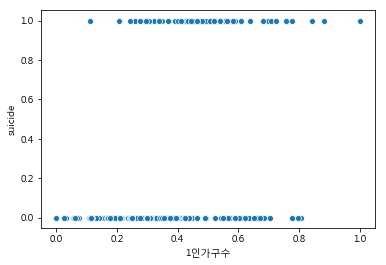

In [22]:
sns.scatterplot(x=sigungu_x_15scaled['1인가구수'],y=sigungu_y['suicide'])

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


AttributeError: 'AxesSubplot' object has no attribute 'label'

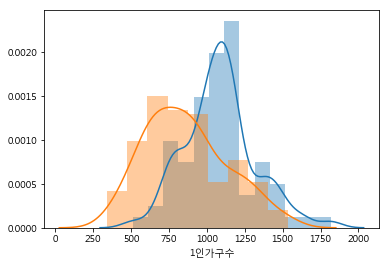

In [23]:
ax = sns.distplot(sigungu.loc[sigungu.자살==1]['1인가구수'], label=['위험군'])
ax = sns.distplot(sigungu.loc[sigungu.자살==0]['1인가구수'], label=['안전지역'])
ax.label

In [ ]:
sns.distplot(sigungu.loc[sigungu.자살==1]['기초수급자수(65세이상)'])
sns.distplot(sigungu.loc[sigungu.자살==0]['기초수급자수(65세이상)'])

In [ ]:
sns.scatterplot(x=sigungu['기초수급자수(65세이상)'],y=sigungu['1인가구수'])

In [ ]:
corr_df

In [ ]:
plt.figure(figsize=(100,100))
sns.heatmap(corr_df, cmap='RdBu')